# Recharge Example
In this example the use of the `TseriesRecharge class` is explained. This `Tseries class` is developed to calculate the recharge series from the measured evaporation and precipitation series. Different recharge models are available: Linear, Preferential, Percolation, and Combination model. More information on these recharge models can be found in [1]. In this examples the `Linear()` and the `Preferential()` recharge model are demonstrated. 

### Compiling recharge models
It is highly recommended to compile the non-linear recharge models when you consider to extensively use these models. Compiling the provided c-file reduces computation time up to 35 times. For example, the calibration of the preferential recharge model applied in this notebook takes 15 seconds when compiled, and around 7 minutes when not compiled. Instructions for compilation of the c-files are available.

### References

[1] R.A. Collenteur [2016] Non-linear time series analysis of deep groundwater
levels: Application to the Veluwe. MSc. thesis, TU Delft.
http://repository.tudelft.nl/view/ir/uuid:baf4fc8c-6311-407c-b01f-c80a96ecd584/

In [1]:
# First perform the necessary imports
import pandas as pd
import matplotlib.dates as md
import matplotlib.pyplot as plt
from pasta import *
%matplotlib notebook

## 1. Importing the observed groundwater levels
The groundwater levels used in this examples are from a well near Apeldoorn, The Netherlands. The area is characterized by a thick unsaturated zone of over 50 meters thick. The groundwater levels are available from 1974-2010. Pandas `read_csv` function is used to load the csv file. The measured groundwater levels are located in the column names "Stand (cm t.o.v. NAP)" (NAP is the Dutch national reference level). The final observed time series is stored as a Pandas `Series` object names `oseries`.

<IPython.core.display.Javascript object>


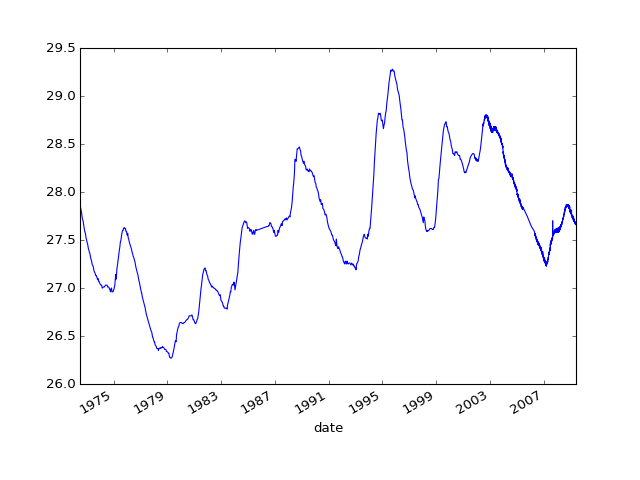

In [9]:
# Import and check the observed groundwater time series
parse = lambda x: md.datetime.datetime.strptime(x, '%d-%m-%Y')
gwdata = pd.read_csv('../data/B33A0113001_1.csv', index_col=2, 
                     skiprows=15, usecols=[2, 5], parse_dates=True,
                     date_parser=parse)

gwdata.rename(columns={'Stand (cm t.o.v. NAP)': 'h'}, inplace=True)
gwdata.index.names = ['date']
gwdata.h *= 0.01  # In meters
oseries = gwdata.h
plt.figure()
oseries.plot()
plt.show()

## 2. Importing the explaining stresses
As explaining series evaporation and precipitation series are used. The evporation is measured at De Bilt and the precipitation in Apeldoorn. The two series are provided in a .txt file, which is again imported using Pandas `read_csv` function. The data is stored as a Pandas `Dataframe` named `data`.

<IPython.core.display.Javascript object>


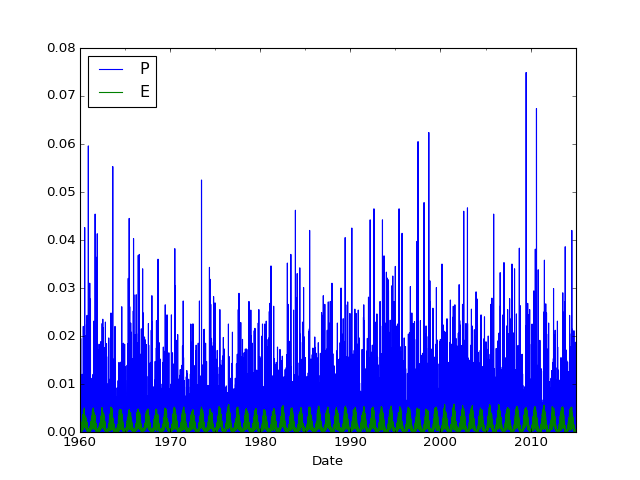

In [10]:
data = pd.read_csv('../data/KNMI_Apeldoorn.txt', skipinitialspace=True, skiprows=12,
                   delimiter=',', parse_dates=[0], index_col=['Date'], usecols=[
        1, 2, 3], names=['Date', 'P', 'E'])
data = data['1960':]  # cut off everything before 1958
data /= 10000.  # In meters
data.plot()
plt.show()

## 3. A linear recharge model
The first time series model that is developed is one with a linear function for the recharge ($R = P - f * E$). We use the `TseriesRecharge` class for this, and tell this class to use the `Linear()` recharge model. 

In [17]:
# Create the time series model with preferential recharge model
ml = Model(oseries)
ts = Recharge(data.P, data.E, Gamma, Linear, name='recharge')
ml.add_tseries(ts)
d = Constant(value=oseries.min())  # Using oseries.min() as initial value slightly
# reduces computation time
ml.add_tseries(d)
n = NoiseModel()
ml.add_noisemodel(n)

Inferred frequency from time series recharge_P: freq=D 
Inferred frequency from time series recharge_E: freq=D 


## 4. A non-linear recharge model
The second model that is developed in this examples uses a preferential flow model to calculate the recharge. Again, we use the `TseriesRecharge` class, and tell this class to use the `Preferential()` recharge model. See [1] for more information on this recharge model. 

In [18]:
# Create the time series model with linear recharge model
ml1 = Model(oseries)
ts1 = Recharge(data.P, data.E, Gamma, Preferential, name='recharge')
ml1.add_tseries(ts1)
d1 = Constant(value=oseries.min())  # Using oseries.min() as initial value slightly

# reduces computation time
ml1.add_tseries(d1)
n1 = NoiseModel()
ml1.add_noisemodel(n1)

Inferred frequency from time series recharge_P: freq=D 
Inferred frequency from time series recharge_E: freq=D 


## 5. Calibration the time series models
The next step is to calibrate the parameters of the model, by calling the solve function on both models. (Solving the models (specifically the preferential model) can take several minutes when the recharge models are not compiled!)

In [21]:
print 'results of the linear recharge model'
print '------------------------------------'
ml.solve(tmin='1975', tmax='2004')
print ""
print 'results of the non-linear recharge model'
print '----------------------------------------'
ml1.solve(tmin='1980', tmax='2004')

results of the linear recharge model
------------------------------------
[[Fit Statistics]]
    # function evals   = 160
    # data points      = 1173
    # variables        = 6
    chi-square         = 9.387
    reduced chi-square = 0.008
    Akaike info crit   = -5645.261
    Bayesian info crit = -5614.857
[[Variables]]
    recharge_A:    2836.56834 +/- 21.98862 (0.78%) (init= 500)
    recharge_n:    2.25146690 +/- 0.011054 (0.49%) (init= 1)
    recharge_a:    456.191474 +/- 7.255334 (1.59%) (init= 100)
    recharge_f:   -0.17640296 +/- 0.059049 (33.47%) (init=-1)
    constant_d:    21.3835570 +/- 0.216538 (1.01%) (init= 26.27)
    noise_alpha:   374.208304 +/- 411.5153 (109.97%) (init= 14)
[[Correlations]] (unreported correlations are <  0.100)
    C(recharge_f, constant_d)    = -0.979 
    C(recharge_a, recharge_f)    = -0.670 
    C(recharge_a, constant_d)    =  0.637 
    C(recharge_A, recharge_f)    = -0.567 
    C(recharge_A, recharge_a)    =  0.467 
    C(recharge_a, noise_al

## 6. Plotting the results
Great! We have solved both models and off course we want to view the resulting simulated groundwater levels. Instead of calling the `ml.plot()` or `ml.plot_results` function to do so, we write some simple code to show the groundwater levels in the same graph.

<IPython.core.display.Javascript object>


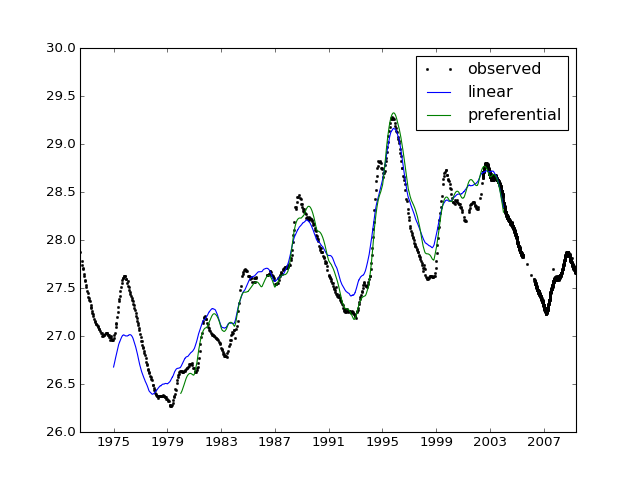

In [22]:
plt.figure()
plt.plot(ml1.oseries, 'ko', markersize=2)
plt.plot(ml.simulate())
plt.plot(ml1.simulate())
plt.ylim([26, 30])
plt.legend(['observed', 'linear', 'preferential'], loc='best')
plt.show()

## 7. Comparing the results using Statistics
PASTA contains a built-in option to calculate statistics that can be used to comparing model performances. 

In [26]:
print 'Not supported yet!'

print 'Statistics for the linear recharge model:'
print ''
#stats = Statistics(ml)
#stats.summary()
print ''
print 'Statistics for the preferential recharge model:'
print ''
#stats1 = Statistics(ml1)
#stats1.summary()

Not supported yet! 
Statistics for the linear recharge model:


Statistics for the preferential recharge model:

